<a href="https://colab.research.google.com/github/stemarzo/DISME/blob/main/05_Quinto_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#QUINTO ASSIGNEMENT: FINE TUNING 

In [ ]:
from tensorflow import keras
keras.__version__

'2.8.0'

In [ ]:
import tarfile
from time import time
from shutil import copyfile

##Esercitazione

### File management

https://colab.research.google.com/notebooks/io.ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
t0 = time()
# Link Google Drive account, transfer dataset, and extract files
copyfile('gdrive/My Drive/101_ObjectCategories_split.tar', '101_ObjectCategories_split.tar')
tar = tarfile.open('101_ObjectCategories_split.tar')
tar.extractall()
tar.close()
print("File transfer completed in %0.3f seconds" % (time() - t0))

File transfer completed in 4.446 seconds


In [ ]:
base_path = '101_ObjectCategories_split/'

### Data loader

A data loader takes care of (at least) the following tasks:

1. Loading input and target data
2. Splitting the dataset into mini batches


**Training set**

https://keras.io/api/preprocessing/image/#imagedatasetfromdirectory-function

In [ ]:
train_dataset = keras.preprocessing.image_dataset_from_directory(base_path+'train',
                                                            image_size=(224,224),
                                                            color_mode='rgb',
                                                            batch_size=32,
                                                            label_mode='categorical',
                                                            shuffle=True,
                                                            seed=1)

Found 4600 files belonging to 102 classes.


Data shuffling (randomization of the instances order) is fundamental in order to ensure that each minibatch is representative of the whole set of classes (or as many classes as possible)

**Test set**

In [ ]:
test_dataset = keras.preprocessing.image_dataset_from_directory(base_path+'test',
                                                            image_size=(224,224),
                                                            color_mode='rgb',
                                                            batch_size=32,
                                                            label_mode='categorical',
                                                            shuffle=True,
                                                            seed=1)

Found 4544 files belonging to 102 classes.


### Loading the base model

https://keras.io/applications/

In [ ]:
# Base model
base_net = keras.applications.MobileNetV2(input_shape=(224,224,3), weights='imagenet', include_top=False, pooling='avg')

9420800/9406464 [==============================] - 0s 0us/step


Let's load a pretrained MobileNet (v2).
*   ``weights`` specifies the dataset used for pretraining
*   ``include_top`` specifies whether to import also the final fully-connected (Dense) layer, mapping to the cardinality of the original problem (1000 classes for imagenet)
*   ``pooling`` specifies whether and how to aggregate the extracted features for each given image



### Model information

In [ ]:
# Number of layers
len(base_net.layers)

155

### Model specialization

In [ ]:
# Freezing the base model (only for finetuning a pretrained model)
for layer in base_net.layers:
    layer.trainable = False

We want to keep (freeze) the weights of all layers that we ''inherited'' from the pretraining on imagenet.

Any subsequent training will only work on the layers that are added in a later time.

In [ ]:
# Explicit input layer
inputs = keras.Input(shape=(224, 224, 3))
x = inputs
# Data augmentation
# x = TODO(x)
# Image preprocessing for consistency with the pretrained model
x = keras.applications.mobilenet_v2.preprocess_input(x)
# Output of the base model
x = base_net(x)
# New intermediate fully-connected layer + ReLU
x = keras.layers.Dense(1024, activation='relu')(x)
# New (final) fully-connected layer + SoftMax activation
outputs = keras.layers.Dense(102, activation='softmax')(x)

We are going to exploit a pre-trained MobileNet.

We must preprocess our images using the exact same procedure that was used during the original training of the network, which we can inherit through ``mobilenet_v2.preprocess_input``

We have built a temporary extension of the base model, adding a first fully-connected layer mapping do 1024 dimensions, a ReLU non-linearity, and one final fully-connected mapping to the problem size (102 classes).

In [ ]:
# Specialized model
net = keras.Model(inputs=inputs, outputs=outputs)

We ''encapsulated'' everything into a new model, which we named ``net``, having the following interface:
* input: a 224$\times$224 placeholder
* output: the output of the model extension (based on Dense layers) which we just defined

In [ ]:
# Print some high-level summaries
net.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                             

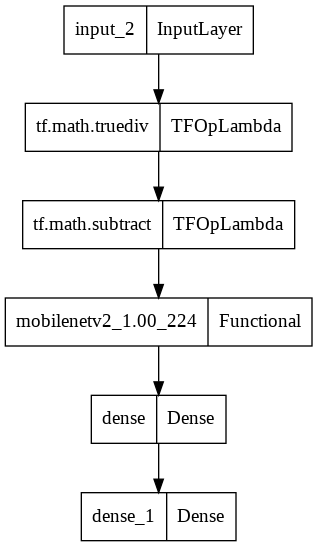

In [ ]:
# Show a high-level architecture
keras.utils.plot_model(net)

### Training (fine-tuning)

In [ ]:
# Compile the model for training
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(),
            metrics=['accuracy'])



We are now using ``fit()`` with a slightly-different syntax with respect to the previous exercise: we delegate to an external module (the data loader) the splitting of the dataset into minibatches:

This formulation still handles indepdendently the various iterations (forward / back-propagation).

```
If x is a dataset, generator, or [...] y should not be specified (since targets will be obtained from x).
[...]
Do not specify the batch_size if your data is in the form of dataset, generator, or [...] (since they generate batches).
```
https://keras.io/api/models/model_training_apis/#fit-method

In [ ]:
# Model training
net.fit(train_dataset,
          epochs=2,
          validation_data=test_dataset);

Epoch 1/2
144/144 [==============================] - 28s 106ms/step - loss: 1.1046 - accuracy: 0.7504 - val_loss: 0.5964 - val_accuracy: 0.8484
Epoch 2/2
144/144 [==============================] - 14s 98ms/step - loss: 0.2161 - accuracy: 0.9376 - val_loss: 0.4659 - val_accuracy: 0.8869


Other potentially useful parameters include:
*   ``steps_per_epoch``: to be computed by dividing the number of examples by ``batch_size``. It can be exploited to run fewer iterations at each epoch, and/or to run the end-epoch validation more frequently.
*   ``validation_steps``: how many validation minibatches should be run at each validation session.



**Note:**

The model status is memorized inside its instance.

So, calling ``fit()`` a second time, will result in resuming the training from where it was left.

If you want to restart the fine-tuning from its initial status (**for example, to assess the effect of different forms of data augmentation**) it is necessary to reload the model and reinitialize the additional weights (see Section ''Model specialization'').

### Evaluation

If the in-training evaluation is performed only with a subsample of the validation set (for example, by specifying the ``validation_steps`` parameter), it can be useful to run a final evaluation over the entire test set.

https://keras.io/api/models/model_training_apis/#evaluate-method

In [ ]:
net.evaluate(test_dataset)

142/142 [==============================] - 7s 51ms/step - loss: 0.4659 - accuracy: 0.8869


[0.4658912420272827, 0.8868837952613831]

### Saving a model

It is possible to save to disk several pieces of information: architecture, weights, as well as the optimizer status:

https://keras.io/api/models/model_saving_apis/

In [ ]:
# net = keras.models.load_model('mymodel_101.h5')

## Assignment

### Loading the base model

In [ ]:
base_net_resnet = keras.applications.ResNet101(input_shape=(224,224,3), weights='imagenet', include_top=False,)

171458560/171446536 [==============================] - 1s 0us/step


### Model specialization

In [ ]:
for layer in base_net_resnet.layers:
    layer.trainable = False

In [ ]:
# Explicit input layer
inputs = keras.Input(shape=(224, 224, 3))
x = inputs
# Data augmentation
x = keras.layers.RandomFlip(mode= 'horizontal_and_vertical', seed=1)(x)
x = keras.layers.RandomRotation(factor=0.2, fill_mode="reflect",
                                interpolation="bilinear", seed=1,
                                fill_value=0.0)(x)
x = keras.layers.RandomContrast(factor= 0.8, seed=1)(x)
# Image preprocessing for consistency with the pretrained model
x = keras.applications.mobilenet_v2.preprocess_input(x)
# Output of the base model
x = base_net_resnet(x)
x= keras.layers.Flatten()(x)
# New intermediate fully-connected layer + ReLU
x = keras.layers.Dense(1024, activation='relu')(x)
# New (final) fully-connected layer + SoftMax activation
outputs = keras.layers.Dense(102, activation='softmax')(x)

In [ ]:
# Specialized model
net_resnet = keras.Model(inputs=inputs, outputs=outputs)

### Training (fine-tuning)

In [ ]:
# Compile the model for training
net_resnet.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(),
            metrics=['accuracy'])

In [ ]:
# Model training
net_resnet.fit(train_dataset,
          epochs=10,
          validation_data=test_dataset);

Epoch 1/10
144/144 [==============================] - 64s 395ms/step - loss: 17.3564 - accuracy: 0.1035 - val_loss: 3.9461 - val_accuracy: 0.1741
Epoch 2/10
144/144 [==============================] - 56s 386ms/step - loss: 4.1195 - accuracy: 0.1574 - val_loss: 3.7486 - val_accuracy: 0.2229
Epoch 3/10
144/144 [==============================] - 55s 384ms/step - loss: 4.0139 - accuracy: 0.1737 - val_loss: 3.6168 - val_accuracy: 0.2249
Epoch 4/10
144/144 [==============================] - 56s 386ms/step - loss: 3.8595 - accuracy: 0.2059 - val_loss: 3.5715 - val_accuracy: 0.2749
Epoch 5/10
144/144 [==============================] - 56s 385ms/step - loss: 3.7456 - accuracy: 0.2198 - val_loss: 3.4509 - val_accuracy: 0.2768
Epoch 6/10
144/144 [==============================] - 56s 385ms/step - loss: 3.6942 - accuracy: 0.2270 - val_loss: 3.6060 - val_accuracy: 0.2496
Epoch 7/10
144/144 [==============================] - 55s 383ms/step - loss: 3.6101 - accuracy: 0.2489 - val_loss: 3.5359 - val_a

### Evaluation

In [ ]:
net_resnet.evaluate(test_dataset)

142/142 [==============================] - 24s 167ms/step - loss: 3.2948 - accuracy: 0.3275


[3.2948009967803955, 0.3274647891521454]